## Informe sobre Heap


In [72]:
#%pip install elasticsearch
#%pip install pandas
#%pip install matplotlib
#%pip install numpy
#%pip install seaborn
#%pip install sklearn
#%pip install scipy
#%pip install nltk

In [73]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from elasticsearch.exceptions import NotFoundError, TransportError
import pandas as pd
import argparse
import re
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import nltk
from nltk.corpus import stopwords



In [74]:
def is_valid_word(word):
    english_re = r"^[a-zA-Z-']+$"
    return bool(re.fullmatch(english_re, word))

nltk.download("stopwords")
english_stopwords = set(stopwords.words("english"))
np.set_printoptions(suppress=True)


[nltk_data] Downloading package stopwords to /Users/nico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Configuración del cliente de Elasticsearch

Para este caso, usaremos los articulos cientificos y novels que son mas amplios

In [75]:
index_novels = 'novels'
index_scientific = 'scientific'

In [76]:
try:
    client = Elasticsearch(hosts=['http://localhost:9200'], request_timeout=1000)
    
    sc_novels = scan(client, index=index_novels, query={"query": {"match_all": {}}})
except TransportError as e:
    print(f"Error de conexión: {e}")
    exit(1)



In [77]:
try:
    sc_scientific = scan(client, index=index_scientific, query={"query": {"match_all": {}}})
except TransportError as e:
    print(f"Error de conexión: {e}")
    exit(1)

### Recolección de términos y sus frecuencias


In [78]:
vocab_novels = {}
vocab_scientific = {}
xdata_novels = 0
xdata_scientific = 0
for s in sc_novels:
    tv = client.termvectors(index=index_novels, id=s['_id'], fields=['text'])
    if 'text' in tv['term_vectors']:
        for t in tv['term_vectors']['text']['terms']:
            term_freq = tv['term_vectors']['text']['terms'][t]['term_freq']
            xdata_novels += term_freq
            if is_valid_word(t):
                if t in vocab_novels:
                    vocab_novels[t] += term_freq
                else:
                    vocab_novels[t] = term_freq



for s in sc_scientific:
    tv = client.termvectors(index=index_scientific, id=s['_id'], fields=['text'])
    if 'text' in tv['term_vectors']:
        for t in tv['term_vectors']['text']['terms']:
            term_freq = tv['term_vectors']['text']['terms'][t]['term_freq']
            xdata_scientific += term_freq
            if is_valid_word(t):
                if t in vocab_scientific:
                    vocab_scientific[t] += term_freq
                else:
                    vocab_scientific[t] = term_freq


/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_32441/1618309800.py:5: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  for s in sc_novels:
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_32441/1618309800.py:6: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  tv = client.termvectors(index=index_novels, id=s['_id'], fields=['text'])
/var/folders/1c/k17dvp9157q8zrkvz60k2wsm0000gn/T/ipykernel_32441/1618309800.py:19: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessi

## Cleaning the datasets

In [79]:
# Convertir a DataFrame como antes
vocabFreqNovels = [(v, freq) for v, freq in vocab_novels.items() if not v.isdigit()]
ydata_novels = len(vocabFreqNovels)
print(ydata_novels)
df_novels = pd.DataFrame(vocabFreqNovels, columns=['Word', 'Count'])

vocabFreqScientific = [(v, freq) for v, freq in vocab_scientific.items() if not v.isdigit()]
ydata_scientific = len(vocabFreqScientific)
print(ydata_novels)
df_scientific = pd.DataFrame(vocabFreqScientific, columns=['Word', 'Count'])

55774
55774


## Ordering and ranking the terms

In [80]:
df_novels = df_novels.sort_values(by='Count', ascending=True).reset_index(drop=True)
df_novels['Ranking'] = df_novels.index + 1

pal_novels = df_novels['Word'].values
freq_novels = df_novels['Count'].values
rankings_novels = df_novels['Ranking'].values

df_scientific = df_scientific.sort_values(by='Count', ascending=True).reset_index(drop=True)
df_scientific['Ranking'] = df_scientific.index + 1

pal_scientific = df_scientific['Word'].values
freq_scientific = df_scientific['Count'].values
rankings_scientific = df_scientific['Ranking'].values

In [81]:
df_novels.head(10)

,Word,Count,Ranking
0,completer,1,1
1,sympathisers,1,2
2,syllogistically,1,3
3,syllogismon,1,4
4,syllogiser,1,5
5,syllogisasthai,1,6
6,suprasensual,1,7
7,supramicroscopical,1,8
8,supponunt,1,9
9,supervenes,1,10


In [82]:
df_scientific.head(10)

,Word,Count,Ranking
0,fellers,1,1
1,bessette,1,2
2,helena,1,3
3,endears,1,4
4,thickwire,1,5
5,klr,1,6
6,proctologists,1,7
7,csr,1,8
8,bimotas,1,9
9,brodney,1,10


## Visualization

In [83]:
def heap_function(n, k, b):
    return k * np.power(n, b)


In [84]:
def compute_heap_estimated_values(N, k, b):
  return [heap_function(n, k, b) for n in N]

In [87]:
# Definir correctamente los datos de entrada para curve_fit
xdata_novels = rankings_novels  # Rankings de las palabras
ydata_novels = freq_novels      # Frecuencias de las palabras

xdata_scientific = rankings_scientific
ydata_scientific = freq_scientific

# Ajuste de curve_fit con parámetros iniciales
initial_params = [1, 0.5]  # Estimaciones iniciales de k y b
bounds = ([0, 0], [np.inf, np.inf])  # Restricciones para que k y b sean >= 0
max_iterations = 10000

# Ajuste para novelas
params_novels, _ = curve_fit(heap_function, xdata_novels, ydata_novels, p0=initial_params, bounds=bounds, maxfev=max_iterations)
y_heap_novels = compute_heap_estimated_values(rankings_novels, params_novels[0], params_novels[1])

# Ajuste para artículos científicos
params_scientific, _ = curve_fit(heap_function, xdata_scientific, ydata_scientific, p0=initial_params, bounds=bounds, maxfev = max_iterations)
y_heap_scientific = compute_heap_estimated_values(rankings_scientific, params_scientific[0], params_scientific[1])


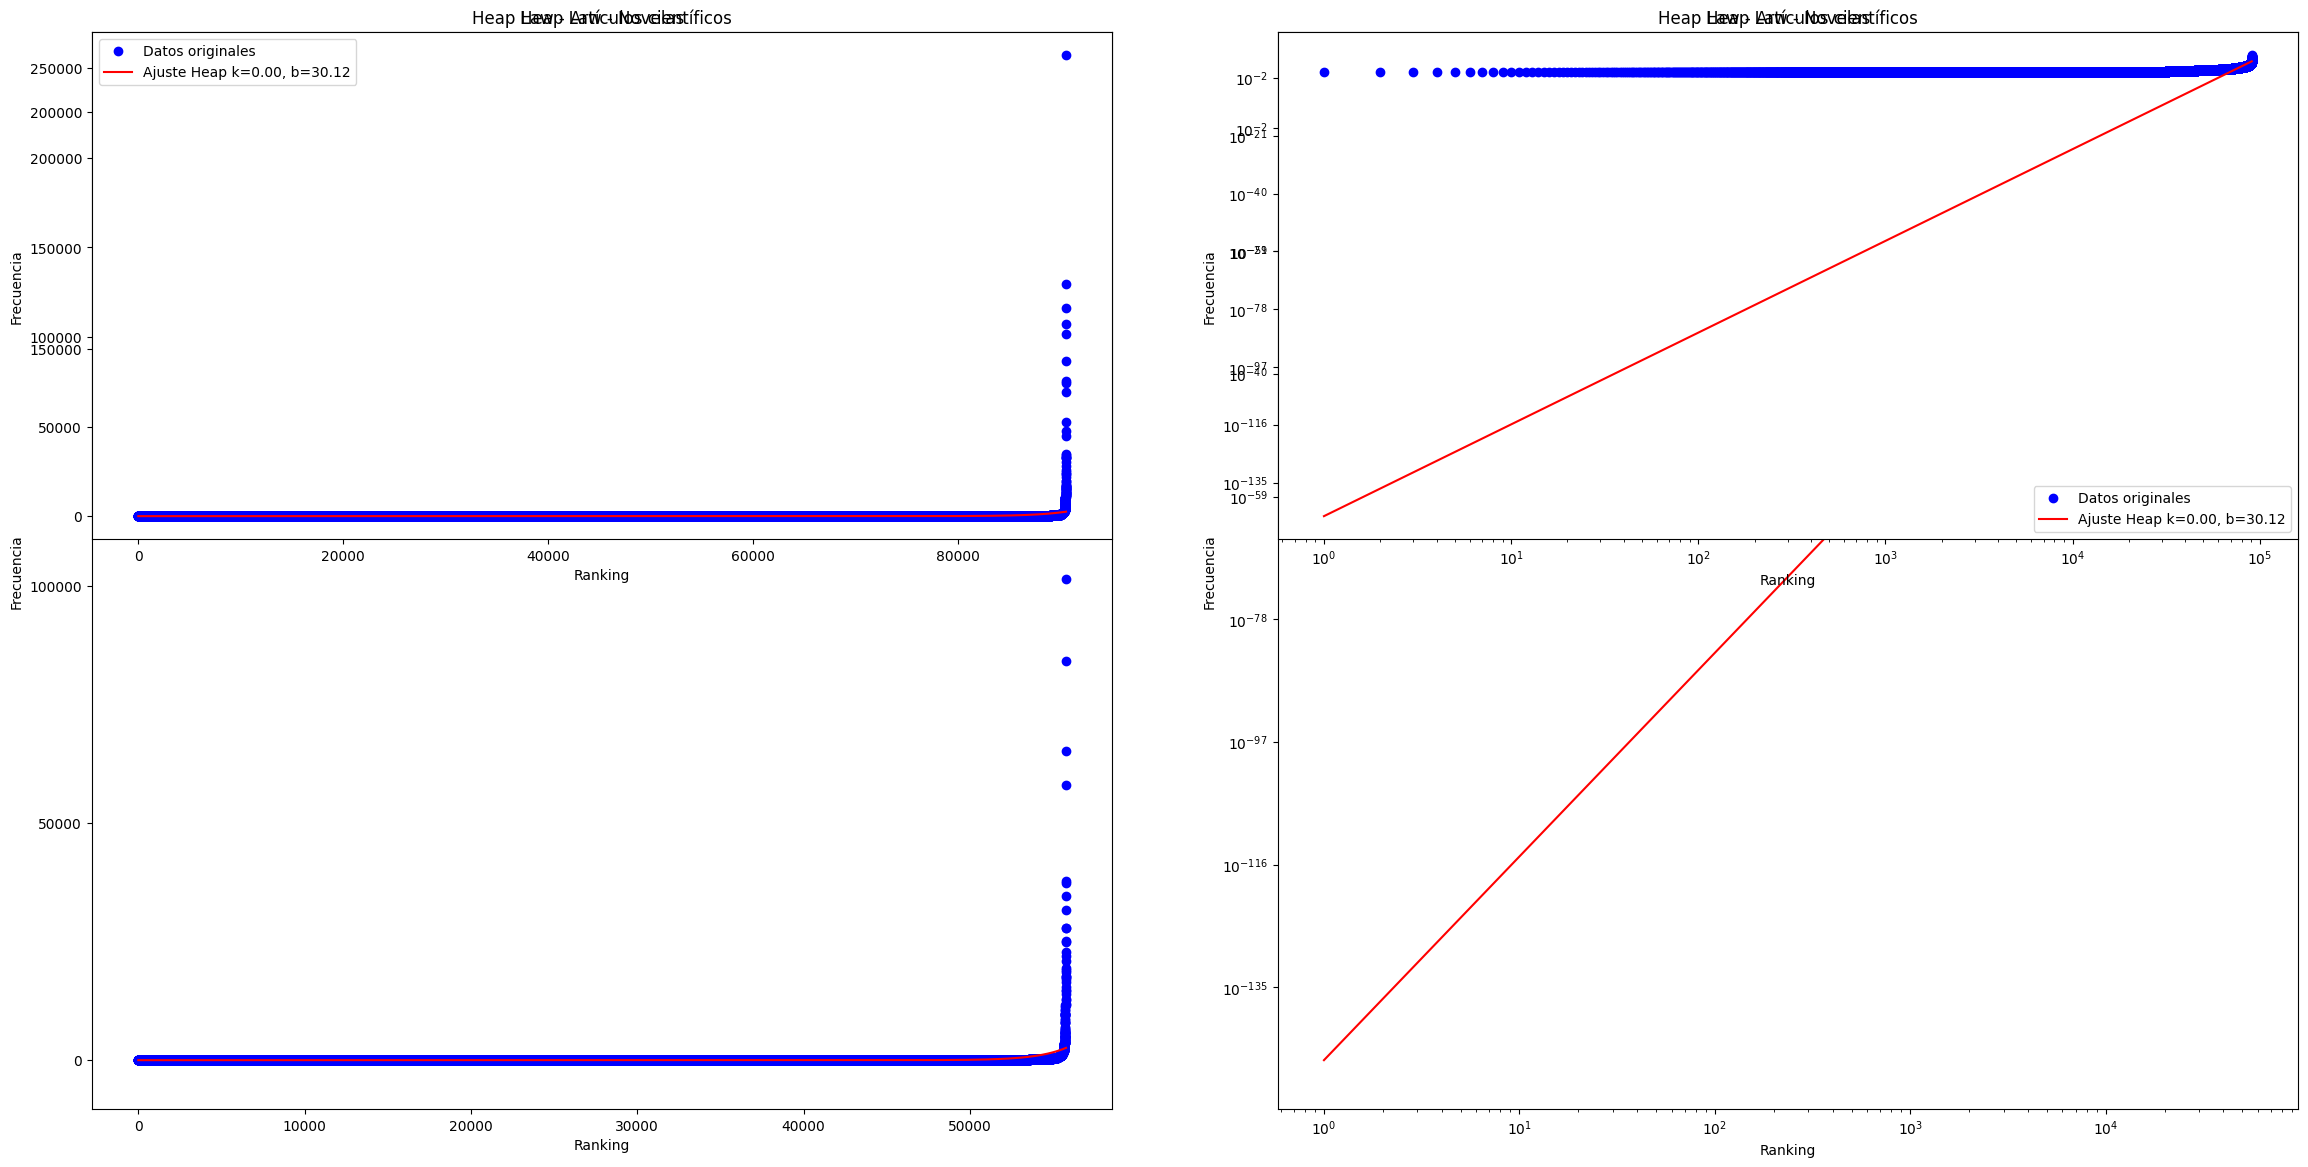

In [90]:
plt.figure(figsize=(24, 12))

# Gráfico para novelas
plt.subplot(1, 2, 1)
plt.plot(rankings_novels, freq_novels, 'bo', label='Datos originales')
plt.plot(rankings_novels, y_heap_novels, 'r-', label=f'Ajuste Heap k={params_novels[0]:.2f}, b={params_novels[1]:.2f}')
plt.xlabel('Ranking')
plt.ylabel('Frecuencia')
plt.title('Heap Law - Novelas')
plt.legend()

# Grafico para novelas en log-log
plt.subplot(1, 2, 2)
plt.loglog(rankings_novels, freq_novels, 'bo', label='Datos originales')
plt.loglog(rankings_novels, y_heap_novels, 'r-', label=f'Ajuste Heap k={params_novels[0]:.2f}, b={params_novels[1]:.2f}')
plt.xlabel('Ranking')
plt.ylabel('Frecuencia')
plt.title('Heap Law - Novelas')
plt.legend()

# Gráfico para artículos científicos
plt.subplot(2, 2, 1)
plt.plot(rankings_scientific, freq_scientific, 'bo', label='Datos originales')
plt.plot(rankings_scientific, y_heap_scientific, 'r-', label=f'Ajuste Heap k={params_scientific[0]:.2f}, b={params_scientific[1]:.2f}')
plt.xlabel('Ranking')
plt.ylabel('Frecuencia')
plt.title('Heap Law - Artículos científicos')
plt.legend()

# Gráfico para artículos científicos en log-log
plt.subplot(2, 2, 2)
plt.loglog(rankings_scientific, freq_scientific, 'bo', label='Datos originales')
plt.loglog(rankings_scientific, y_heap_scientific, 'r-', label=f'Ajuste Heap k={params_scientific[0]:.2f}, b={params_scientific[1]:.2f}')
plt.xlabel('Ranking')
plt.ylabel('Frecuencia')
plt.title('Heap Law - Artículos científicos')
plt.legend()


plt.tight_layout()
plt.show()